In [58]:
from typing import Iterator, Iterable, Mapping, Sequence, Tuple
from rl.markov_process import TransitionStep, S
from rl.function_approx import X

Question 2.a. (Tabular TD(λ))

In [48]:
def td_lambda_tabular_prediction(
        transitions: Iterable[TransitionStep[S]],
        γ: float,
        λ: float,
        alpha = 0.03,
        beta = 0.5,
        H = 1000
) -> Iterator[Mapping[X, float]]:
    values_map: Mapping[X, float] = {}
    eligibility: Mapping[X,float] = {}
    eligibility_help: Mapping[X,int] = {} #record last time this transition.state comes
    counts:int = 1
    count_to_weight_func: Callable[[int], float] = lambda n: alph/(1+((n-1)/H)**beta)

    yield values_map

    for transition in transitions:
        weight:float = count_to_weight_func(counts)

        ##update eligibility
        eligibility.setdefault(transition.state, 0.)
        eligibility_help.setdefault(transition.state, 0)
        eligibility[transition.state] *= (γ * λ) ** (counts - eligibility_help[transition.state])
        eligibility[transition.state] += 1

        ##update values_map
        values_map.setdefault(transition.state, 0.)
        values_map[transition.state] += weight * (transition.reward + γ * values_map.get(transition.next_state, 0.) - values_map[transition.state]) * eligibility[transition.state]

        counts += 1
        eligibility_help[transition.state] = counts

        yield values_map

Question 2.b. (Function Approx TD(λ))

In [45]:
import rl.markov_process as mp
import numpy as np
from rl.function_approx import Gradient
from rl.approximate_dynamic_programming import ValueFunctionApprox
from rl.approximate_dynamic_programming import extended_vf

def td_FuncApprox_lambda_prediction(
        transitions: Iterable[mp.TransitionStep[S]],
        approx_0: ValueFunctionApprox[S],
        γ: float,
        λ: float
) -> Iterator[ValueFunctionApprox[S]]:
    func_approx: ValueFunctionApprox[S] = approx_0
    yield func_approx

    for transition in transitions:
        eligibility_trace: Gradient[ValueFunctionApprox[S]] = Gradient(func_approx).zero()
        delta: float = func_approx(transition.state) \
                - (transition.reward + γ * extended_vf(func_approx, transition.next_state))

        ##update eligibility trace (get the "derivative")
        eligibility_trace *= (γ * λ)
        eligibility_trace += func_approx.objective_gradient(
            xy_vals_seq=[(transition.state, 0)],
            obj_deriv_out_fun=lambda x1, y1: np.ones(len(x1)))

        ##update func_approx (with the "derivative")
        func_approx = func_approx.update_with_gradient(
            eligibility_trace * delta)

        yield func_approx

Question 3. (Proof)
By definition, we have $G_t = \sum_{u = t}^{T-1} \gamma^{u - t}\cdot R_{u+1}$. Then observe that the remaining terms on the righthand side is actually a telescope sum:
\begin{align}
    \sum_{u = t}^{T-1} (\gamma^{u - t + 1}\cdot V(S_{u + 1}) - \gamma^{u - t}\cdot V(S_{u})) = \gamma^{T-t
    }\cdot V(S_T) - V(S_t) = - V(S_t).
\end{align}
Combine these two equations together, we have proved the provided formula.

Question 4. (Compare different algorithms)

In [46]:
# Construct testing process
from rl.markov_process import NonTerminal
from rl.chapter2.simple_inventory_mrp import InventoryState
from rl.chapter2.simple_inventory_mrp import SimpleInventoryMRPFinite
from rl.markov_process import FiniteMarkovRewardProcess

## Set parameters
user_capacity = 2
user_poisson_lambda = 1.0
user_holding_cost = 1.0
user_stockout_cost = 10.0
user_gamma = 0.9

si_mrp = SimpleInventoryMRPFinite(
    capacity=user_capacity,
    poisson_lambda=user_poisson_lambda,
    holding_cost=user_holding_cost,
    stockout_cost=user_stockout_cost
)

Initial_InventoryState = NonTerminal(InventoryState(0,0))

In [49]:
# test using TD in the BOOK
from rl.td import td_prediction
from rl.distribution import Constant
from rl.function_approx import Tabular
import rl.iterate as iterate
import itertools
from pprint import pprint

user_episode_length = 100
user_num_episodes = 1000

user_lambda = 0.3

# parameters in learning rate
alph = 0.03
beta = 0.5
H = 1000

pred_td: Iterator[ValueFunctionApprox[S]] = td_prediction(
         transitions = si_mrp.simulate_reward(Constant(Initial_InventoryState)),
         approx_0 = Tabular(count_to_weight_func = lambda n: alph/(1+((n-1)/H)**beta)),
         γ = user_gamma)
pred_td_tabular: ValueFunctionApprox[S] \
    = iterate.last(itertools.islice(pred_td, user_episode_length * user_num_episodes))

print("Tabular TD in book")
pprint({s: pred_td_tabular(s) for s in si_mrp.non_terminal_states})

pred_td_lambda_test: Iterator[ValueFunctionApprox[S]] = td_lambda_tabular_prediction(
                     transitions = si_mrp.simulate_reward(Constant(Initial_InventoryState)),
                     γ = user_gamma,
                     λ = user_lambda
)
pred_td_lambda_tabular_test: Mapping[X, float] \
    = iterate.last(itertools.islice(pred_td_lambda_test, user_episode_length * user_num_episodes))

print("Self-made Tabular TD(λ)")
pprint({s: pred_td_lambda_tabular_test[s] for s in si_mrp.non_terminal_states})

pred_td_lambda_FuncApprox: Iterator[ValueFunctionApprox[S]] = td_FuncApprox_lambda_prediction(
                     transitions = si_mrp.simulate_reward(Constant(Initial_InventoryState)),
                     approx_0 = Tabular(count_to_weight_func = lambda n: alph/(1+((n-1)/H)**beta)),
                     γ = user_gamma,
                     λ = user_lambda
)
pred_td_lambda_FuncApprox_test: Mapping[X, float] \
    = iterate.last(itertools.islice(pred_td_lambda_FuncApprox, user_episode_length * user_num_episodes))

print("Self-made FuncApprox TD(λ)")
pprint({s: pred_td_lambda_FuncApprox_test(s) for s in si_mrp.non_terminal_states})

Tabular TD in book
{NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -35.557116730012254,
 NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -28.15015164377261,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -29.24635777366274,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -27.993544994405543,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -28.966474319976125,
 NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -30.50149169609973}
Self-made Tabular TD(λ)
{NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -35.546839206847224,
 NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -28.426661965027535,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -29.56544812505303,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -27.991963238015185,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -28.886156803257233,
 NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -30.449103010222608}
S

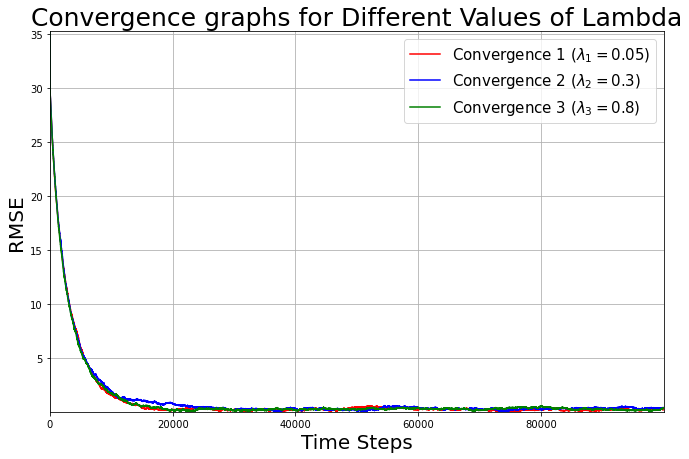

In [70]:

# plot graphs of convergence for different λ
import numpy as np
from rl.gen_utils.plot_funcs import plot_list_of_curves

test_lamb: Sequence[float] = [0.05, 0.3, 0.8]
rmse_values: Sequence[Sequence[float]] = []

for lamb in test_lamb:
    pred_td_lambda_compare: Iterator[ValueFunctionApprox[S]] = td_FuncApprox_lambda_prediction(
                            transitions = si_mrp.simulate_reward(Constant(Initial_InventoryState)),
                            approx_0 = Tabular(count_to_weight_func = lambda n: alph/(1+((n-1)/H)**beta)),
                            γ = user_gamma,
                            λ = lamb
    )

    rmse:Sequence[float] = []
    pred_next = next(pred_td_lambda_compare)
    for _ in range(user_episode_length * user_num_episodes):
        pred_next = next(pred_td_lambda_compare)
        xy_vals_seq: Sequence[Tuple[X,float]] = [(key, pred_td_lambda_FuncApprox_test(key))
                       for key in pred_next.values_map.keys()]
        rmse.append(pred_next.rmse(xy_vals_seq = xy_vals_seq))

    rmse_values.append(rmse)

plot_list_of_curves(
        [range(user_episode_length * user_num_episodes)] * 3,
        [rmse_values[0], rmse_values[1], rmse_values[2]],
        ["r", "b", "g"],
        [
            r"Convergence 1 ($\lambda_1=0.05$)",
            r"Convergence 2 ($\lambda_2=0.3$)",
            r"Convergence 3 ($\lambda_3=0.8$)"
        ],
        "Time Steps",
        "RMSE",
        "Convergence graphs for Different Values of Lambda"
    )